In [1]:
cd TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
from BB2tile import *
# from dataset import Dataset

Populating the interactive namespace from numpy and matplotlib


- ~~throw away worker responses that contain all-zero rrows (they probably did not draw any important region since nothing they drew agreed with others )~~

In [7]:
bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [COCO]']!=0][bb_info['Jaccard [Self]']!=0].sort('object_id')
object_id_lst  = list(set(obj_sorted_tbl.object_id))
img_info,object_tbl,bb_info,hit_info = load_info()
objid=38
bb_objects  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]
worker_lst  = np.unique(bb_objects.worker_id)

In [25]:
indicator_matrix = objIndicatorMat
#for all the workers with all-zero rows
for wi in np.where(np.sum(indicator_matrix,axis=1)==0)[0]:
    worker_id = worker_lst[wi]
    worker_bb_info = bb_objects[bb_objects["worker_id"]==worker_id]
    worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]])))
    dist_lst = []
    for tile_i in range(len(tiles)): 
        #Take the transpose of the tile graph polygon because during the tile creation process the xy was flipped
        tile = Polygon(zip(tiles[tile_i][:,1],tiles[tile_i][:,0]))
        #Find the closest tile that corresponds to that worker
        dist_lst.append(worker_BB_polygon.distance(tile))
    argmin_dist_idx = np.where(dist_lst==min(np.array(dist_lst)))[0]
    for min_dist_idx in argmin_dist_idx:
        indicator_matrix[wi][tile_i]=1

In [12]:
def createObjIndicatorMatrix(objid,PLOT=False,sampleNworkers=-1,PRINT=False):
    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_objects = bb_info[bb_info["object_id"]==objid]
    # Sampling Data from Ji table 
    if sampleNworkers>0 and sampleNworkers<len(bb_objects):
        bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
    # Create a masked image for the object
    # where each of the worker BB is considered a mask and overlaid on top of each other 
    img_name = img_info[img_info.id==int(object_tbl[object_tbl.id==objid]["image_id"])]["filename"].iloc[0]
    fname = "../web-app/app/static/"+img_name+".png"
    img=mpimg.imread(fname)
    width,height = get_size(fname)
    mega_mask = np.zeros((height,width))
    img = Image.new('L', (width, height), 0)
    obj_x_locs = [process_raw_locs([x,y])[0] for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
    obj_y_locs = [process_raw_locs([x,y])[1] for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
    for x_locs, y_locs in zip(obj_x_locs,obj_y_locs):
        ImageDraw.Draw(img).polygon(zip(x_locs,y_locs), outline=1, fill=1)
        mask = np.array(img)==1
        mega_mask+=mask
    if PLOT: 
        # Visualize mega_mask
        plt.figure(figsize=(5,10))
        plt.imshow(mega_mask)
        plt.colorbar()

    # Create masks for single valued tiles (so that they are more disconnected)
    from matplotlib import _cntr as cntr
    tiles = [] # list of coordinates of all the tiles extracted
    unique_tile_values = np.unique(mega_mask)
    for tile_value in unique_tile_values:
        singly_masked_img = np.zeros_like(mega_mask)
        for x,y in zip(*np.where(mega_mask==tile_value)):
            singly_masked_img[x][y]=1
        #Extract a set of contours from these masks
        x, y = np.mgrid[:singly_masked_img.shape[0], :singly_masked_img.shape[1]]
        c = cntr.Cntr(x, y, singly_masked_img)
        # trace a contour at z ~= 1
        res = c.trace(0.9)
        if PLOT: plot_trace_contours(res)
        for segment in res:
            if segment.dtype!=np.uint8 and len(segment)>2:
                #Take the transpose of the tile graph polygon because during the tile creation process the xy was flipped
                tile= Polygon(zip(segment[:,1],segment[:,0]))
                # print tile.area
                if tile.area>=1:
                    tiles.append(segment)

    # Convert set of tiles to indicator matrix for all workers and tiles
    # by checking if the worker's BB contains the tile pieces
    # The indicator matrix is a (N + 1) X M matrix, 
    # with first N rows indicator vectors for each annotator and
    # the last row being region sizes
    M = len(tiles)
    worker_lst  = np.unique(bb_objects.worker_id)
    N = len(worker_lst)
    if PRINT: 
        print "Number of non-overlapping tile regions (M) : ",M
        print "Number of workers (N) : ",N
    indicator_matrix = np.zeros((N+1,M),dtype=int)
    for  wi in range(N):
        worker_id = worker_lst[wi]
        worker_bb_info = bb_objects[bb_objects["worker_id"]==worker_id]
        worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]])))
        # Check if worker's polygon contains this tile
        for tile_i in range(M):
            # tile = Polygon(tiles[tile_i])
            tile= Polygon(zip(tiles[tile_i][:,1],tiles[tile_i][:,0]))
            # Check that tiles are indeed close to BB (no mis-alignment issue)
            if PLOT and tile_i==0:
                plt.figure()
                plot_coords(tile)
                plot_coords(worker_BB_polygon,color="blue")
            if worker_BB_polygon.contains(tile): #or tile.contains(worker_BB_polygon): 
                indicator_matrix[wi][tile_i]=1

    # The last row of the indicator matrix is the tile area
    for tile_i in range(M):
        tile= Polygon(zip(tiles[tile_i][:,1],tiles[tile_i][:,0]))
        indicator_matrix[-1][tile_i]=tile.area

    #for all the workers with all-zero rows
    for wi in np.where(np.sum(indicator_matrix,axis=1)==0)[0]:
        worker_id = worker_lst[wi]
        worker_bb_info = bb_objects[bb_objects["worker_id"]==worker_id]
        worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]])))
        dist_lst = []
        for tile_i in range(len(tiles)): 
            #Take the transpose of the tile graph polygon because during the tile creation process the xy was flipped
            tile = Polygon(zip(tiles[tile_i][:,1],tiles[tile_i][:,0]))
            #Find the closest tile that corresponds to that worker
            dist_lst.append(worker_BB_polygon.distance(tile))
        argmin_dist_idx = np.where(dist_lst==min(np.array(dist_lst)))[0]
        for min_dist_idx in argmin_dist_idx:
            indicator_matrix[wi][tile_i]=1

    if PLOT: sanity_check(indicator_matrix)
    return tiles,indicator_matrix


In [22]:
def sanity_check(indicator_matrix): 
    print "Check that there are no all-zero rows in indicator matrix:" , len(np.where(np.sum(indicator_matrix,axis=1)==0)[0])==0
    plt.figure()
    plt.title("Sorted Tile Area")
    sorted_indicator_matrix = indicator_matrix[:,indicator_matrix[-1].argsort()]
    plt.semilogy(sorted_indicator_matrix[-1])
    plt.xlabel("Worker #",fontsize=13)
    plt.ylabel("log (Area)",fontsize=13)
    # plt.plot(sorted_indicator_matrix[-1])
    plt.figure()
    plt.title("Sorted Indicator Matrix")
    plt.xlabel("Worker #",fontsize=13)
    plt.ylabel("Region #",fontsize=13)
    #Plot all excluding last row (area)
    plt.imshow(sorted_indicator_matrix[:-1],cmap="cool",interpolation='none', aspect='auto')
    plt.colorbar()

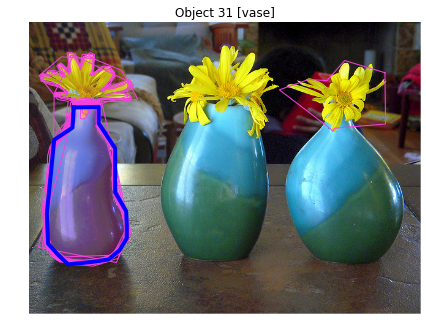

In [24]:
visualize_bb_objects(31)

31
Number of non-overlapping tile regions (M) :  119
Number of workers (N) :  40
Check that there are no all-zero rows in indicator matrix: True
6
Number of non-overlapping tile regions (M) :  24
Number of workers (N) :  40
Check that there are no all-zero rows in indicator matrix: True
11
Number of non-overlapping tile regions (M) :  31
Number of workers (N) :  40
Check that there are no all-zero rows in indicator matrix: True
9
Number of non-overlapping tile regions (M) :  43
Number of workers (N) :  40
Check that there are no all-zero rows in indicator matrix: True
44
Number of non-overlapping tile regions (M) :  94
Number of workers (N) :  40
Check that there are no all-zero rows in indicator matrix: True
12
Number of non-overlapping tile regions (M) :  35
Number of workers (N) :  40
Check that there are no all-zero rows in indicator matrix: True


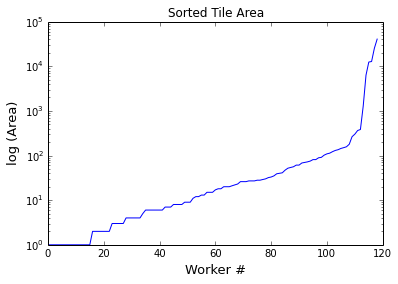

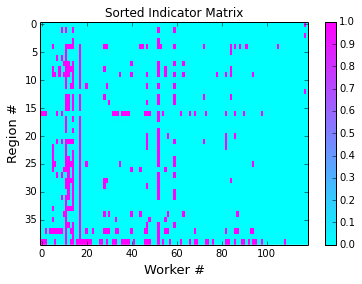

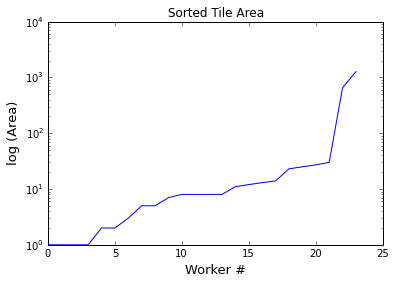

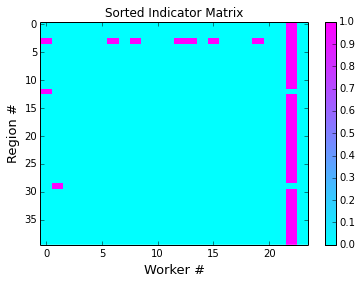

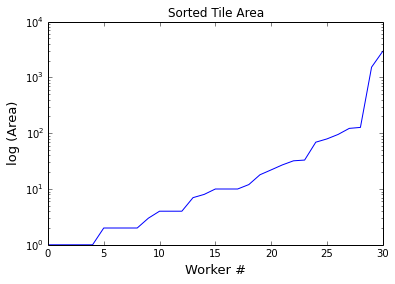

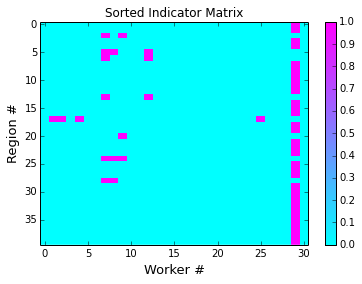

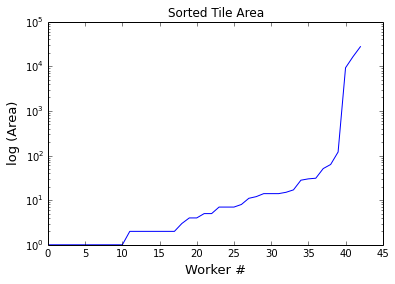

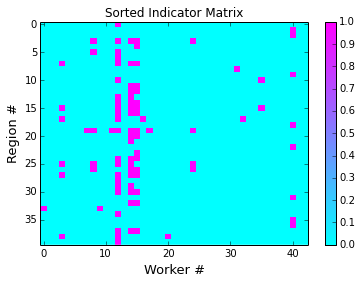

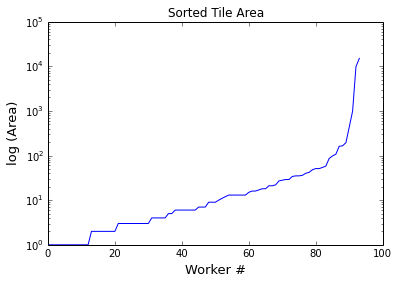

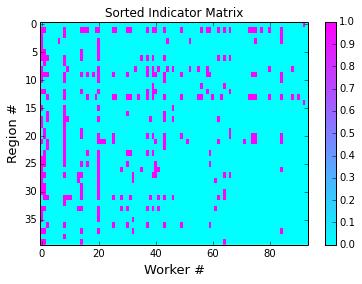

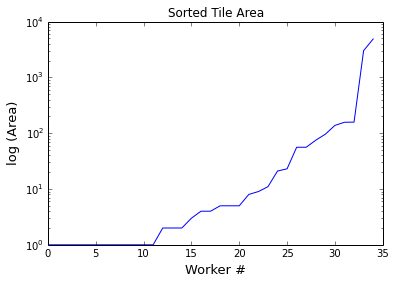

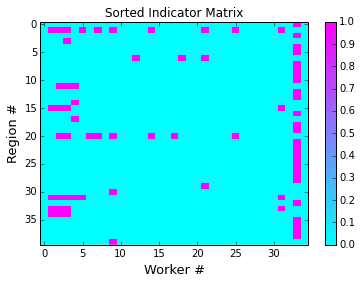

In [23]:
for object_id in [31,6,11,9,44,12]:#[2,7,35,22,18,12,31]:
    print object_id
    tiles, objIndicatorMat = createObjIndicatorMatrix(object_id,sampleNworkers=40,PRINT=True)
    sanity_check(objIndicatorMat)

In [22]:
delete_tile_idx=[0]

In [23]:
for i in delete_tile_idx:l.pop(i)

In [24]:
l

[2, 3]

In [14]:
np.delete(arr,(0,2),axis=1)

array([[0],
       [2],
       [0]])

In [31]:
np.where(np.sum(objIndicatorMat,axis=1)==0)

(array([], dtype=int64),)

Number of non-overlapping tile regions (M) :  118
Number of workers (N) :  10
39523.42
4.82
2.62
2.62
0.82
0.22
0.02
0.22
0.42
0.82
0.22
4.22
4.22
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.22
0.02
0.02
13.22
1.42
0.22
0.62
0.42
6.02
2.42
0.22
0.02
17.42
8.62
0.02
1.02
0.22
0.02
0.22
8.22
6.22
2.82
36.22
34.02
0.82
0.22
20.62
74.82
135.42
0.42
5.02
1.22
0.62
0.62
6.22
0.02
0.02
2.42
0.22
0.22
0.42
8.62
0.02
1.42
0.02
4.62
178.02
0.02
51.22
0.02
55.22
0.22
0.02
6.02
57.22
0.22
0.22
0.42
3.62
22.22
0.82
43.42
0.42
41.42
1.02
3.62
12.22
1.82
54.42
0.02
0.22
1.62
0.42
4.22
0.42
0.62
0.22
18.62
0.62
1.02
8.22
10.82
7.42
118.82
10.02
47.22
0.42
0.42
0.22
0.22
1.02
0.42
65.62
0.02
31.02
0.02
2.62
36675.62
[4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 30, 31, 34, 36, 37, 38, 44, 45, 49, 52, 53, 55, 56, 58, 59, 60, 62, 64, 67, 69, 71, 72, 75, 76, 77, 80, 82, 89, 90, 92, 94, 95, 96, 98, 106, 107, 108, 109, 111, 113, 115]
2.62
deleted tile # 2
Check that there are no all-ze

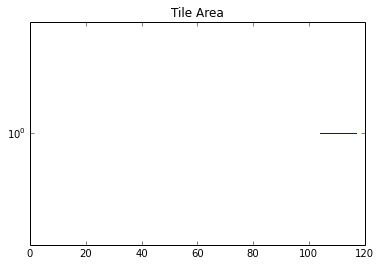

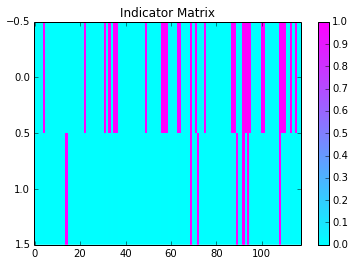

In [27]:
object_id = 38
tiles, objIndicatorMat = createObjIndicatorMatrix(object_id,sampleNworkers=10,PRINT=True)
sanity_check(objIndicatorMat)

In [3]:
np.where(np.sum(objIndicatorMat,axis=1)==0)[0]

NameError: name 'objIndicatorMat' is not defined

In [ ]:
len(np.where(np.sum(objIndicatorMat,axis=1)==0)[0])==0

In [3]:
# Generate M regions; Each region belongs to k annotators of a total of N
TestSet = SimulateSingleObject(N=10,M=50,IntersectionArea=10,MaxAreaOfOtherRegions=100)
TestSet.createNewMapping()

In [4]:
ind = np.array(gen_data(10,100,10,100,10,100))

In [5]:
ind

array([[ 0,  0,  1, ...,  1,  1,  1],
       [ 0,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  0, ...,  1,  1,  1],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1,  1,  1],
       [35, 43, 90, ..., 95, 21, 79]])

Check that there are no all-zero rows in indicator matrix: True


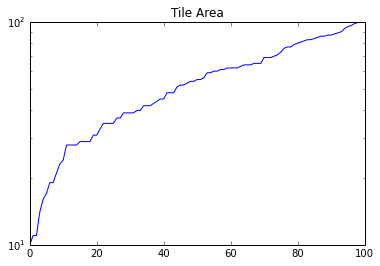

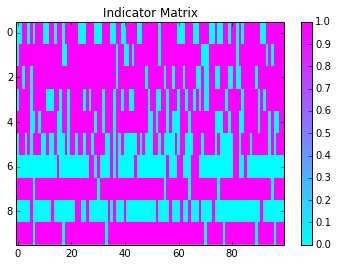

In [7]:
sanity_check(ind)

Number of non-overlapping tile regions (M) :  118
Number of workers (N) :  10
2.62
0.82
Check that there are no all-zero rows in indicator matrix: False


ValueError: Data has no positive values, and therefore can not be log-scaled.

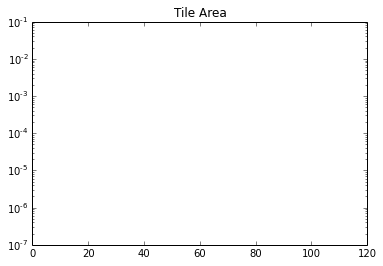

In [3]:
object_id = 38
tiles, objIndicatorMat = createObjIndicatorMatrix(object_id,sampleNworkers=10,PRINT=True)
sanity_check(objIndicatorMat)

Number of non-overlapping tile regions (M) :  118
Number of workers (N) :  10
Check that there are no all-zero rows in indicator matrix: True


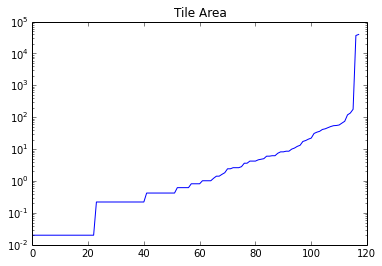

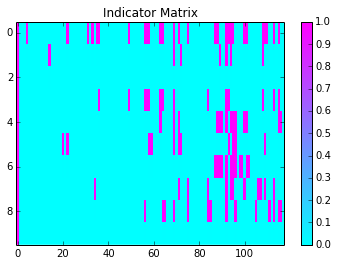

In [4]:
object_id = 38
tiles, objIndicatorMat = createObjIndicatorMatrix(object_id,sampleNworkers=10,PRINT=True)
sanity_check(objIndicatorMat)

Number of non-overlapping tile regions (M) :  118
Number of workers (N) :  10
Check that there are no all-zero rows in indicator matrix: False


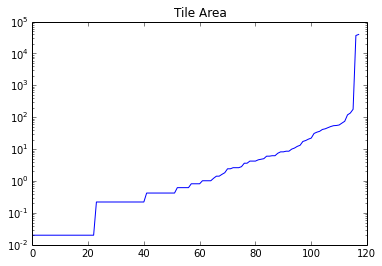

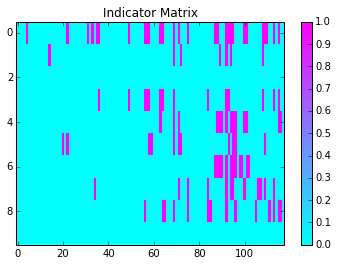

In [3]:
object_id = 38
tiles, objIndicatorMat = createObjIndicatorMatrix(object_id,sampleNworkers=10,PRINT=True)
sanity_check(objIndicatorMat)

In [4]:
def plot_tile_i(tiles,i):
    plot_coords(Polygon(zip(tiles[i][:,1],tiles[i][:,0])))

In [5]:
img_info,object_tbl,bb_info,hit_info = load_info()
obj_lst = list(set(object_tbl.object_id))
my_BBG  = pd.read_csv("my_ground_truth.csv")

In [4]:
# Ta, La, ga, solutionLista = experiment_avg(objIndicatorMat)
Tm, Lm, gm, solutionListm = experiment_median(objIndicatorMat)
# Tl, Ll, gl, solutionListl = experiment_local(1, objIndicatorMat)

Starting Median Experiment with T value 0.0
--------------------------
inf [[ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364843]
 [ 0.95364

- Sampling Ji responses

In [6]:
object_id = 40
tiles, objIndicatorMat = createObjIndicatorMatrix(object_id,sampleNworkers=10,PRINT=True)

Number of non-overlapping tile regions (M) :  26
Number of workers (N) :  10


In [28]:
from tqdm import tqdm 

In [29]:
all_sampleN_lst=[]
for sampleN in tqdm(range(0,41,5)[1:]):
    sampleN_lst=[]
    for object_id in obj_lst:     
        tiles, objIndicatorMat = createObjIndicatorMatrix(object_id,sampleNworkers=sampleN,PRINT=False)
        sampleN_lst.append(len(tiles))
    all_sampleN_lst.append(sampleN_lst)

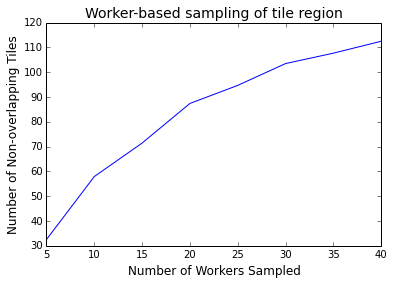

In [32]:
plt.title("Worker-based sampling of tile region",fontsize=14)
plt.xlabel("Number of Workers Sampled",fontsize=12)
plt.ylabel("Number of Non-overlapping Tiles",fontsize=12)
plt.plot(range(0,41,5)[1:],np.mean(all_sampleN_lst,axis=1))
plt.savefig("sampletile.pdf")

In [3]:
object_id = 40
tiles, objIndicatorMat = createObjIndicatorMatrix(object_id,sampleNworkers=20,PRINT=True)

Number of non-overlapping tile regions (M) :  27
Number of workers (N) :  20


In [5]:
Ta, La, ga, solutionLista = experiment_avg(objIndicatorMat)

Starting Average Experiment with T value 774.336
--------------------------
0 + 2 * log(var68.T * [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]) + -log(0.0) + -log(774.336) + 2 * log(var68.T * [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]) + -log(0.0) + -log(774.336) + 2 * log(var68.T * [[    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [    0.  ]
 [ 2004.22]
 [    0.  ]
 [ 1859.42]]) + -log(3863.64) + -log(774.336) + 2 * log(var68.T * [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0

In [17]:
N1,M = shape(objIndicatorMat)

In [11]:
shape(objIndicatorMat[-1])

(27,)

In [19]:
regions = objIndicatorMat[-1]

In [31]:
np.where(objIndicatorMat[:-1]!=0)

(array([ 2,  2, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 15, 15, 15, 17, 17]),
 array([24, 26,  6,  7,  8,  9, 11, 14, 16, 23, 24, 26, 16, 24, 26, 24, 26]))

In [36]:
gammas = ga

The reason why we were getting inf in the log likelihood is because for some of the indicators, the whole indicator vector is zero, so then when you do the matmul, the argument in the log is zero, log(0)=error -->inf. Inituitvely, because each worker made a BB he must have at least 1 non-zero entry in his indicator, i.e his bounding box must contain at least one of his tiles, or small set of his tile. So that mean there is something wrong with the BB2Tile construction of the indicator matrix. 

In [39]:
gammas.T

matrix([[ -7.76818815e-03,   1.61914224e-01,  -4.22916425e-08,
          -4.30767920e-08,  -5.76193395e-07,  -4.03460469e-07,
           9.99535492e-01,   1.00001363e+00,   1.00002475e+00,
           1.00002475e+00,   4.68699136e-01,   1.00002475e+00,
          -7.81117464e-07,  -6.55493513e-07,   9.99953033e-01,
          -4.39801044e-05,   9.99512606e-01,  -3.40351807e-06,
           4.68699136e-01,   1.61914224e-01,  -6.71685207e-06,
          -2.77841160e-04,  -7.32579099e-03,   9.99330336e-01,
           5.54923308e-01,  -7.04583010e-06,   5.87079785e-01]])

In [37]:
f = 0
for i in range(M):
    indicators = objIndicatorMat[i]
    term = 2 * np.log(gammas.T * np.multiply(regions, indicators)) \
            - np.log(np.dot(regions, indicators)) - cvx.log(T)
    f = f + term 

ValueError: shapes (1,27) and (1,27) not aligned: 27 (dim 1) != 1 (dim 0)

In [5]:
Ta, La, ga, solutionLista = experiment_avg(objIndicatorMat)
Tm, Lm, gm, solutionListm = experiment_median(objIndicatorMat)
Tl, Ll, gl, solutionListl = experiment_local(1, objIndicatorMat)

Starting Average Experiment with T value 774.336
--------------------------
Starting Median Experiment with T value 0.0
--------------------------
Starting Local Search with T values between 1 and 200518.06
--------------------------


In [8]:
La

inf

In [50]:
#Exhaustive search is a bit buggy because convex solver yields likelihood as inf 
# Te, Le, ge, solutionListe = experiment_exhaustive(1, objIndicatorMat,step_size=500)

In [ ]:
tile_dataset = Dataset(tiles,objIndicatorMat,100)
solution = greedySearch(tile_dataset)
solution.printSolution()

In [ ]:
Compare with 

------------------------

In [4]:
object_id = 18
ground_truth_match = my_BBG[my_BBG.object_id==object_id]
BBG =  Polygon(zip(*process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])))
tiles, objIndicatorMat = createObjIndicatorMatrix(object_id)
T_true =BBG.area

In [8]:
Ta, La, solutionLista = experiment_avg(objIndicatorMat)
# Tm, Lm, solutionListm = experiment_median(objIndicatorMat)
# Tl, Ll, solutionListl = experiment_local(5000, objIndicatorMat)

NameError: name 'experiment_avg' is not defined

In [10]:
from shapely.ops import cascaded_union

In [11]:
def join_tiles(solutionList,tiles):
    return cascaded_union([Polygon(tiles[tidx]) for tidx in solutionList])

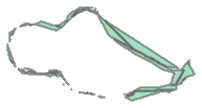

In [35]:
join_tiles(solutionLista,tiles)

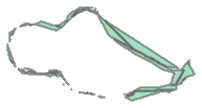

In [39]:
join_tiles(solutionListm,tiles)

# Plotting $\gamma$ probabilities for each tile

In [1]:
La

NameError: name 'La' is not defined